In [1]:
import src.models.question1 as q1
import src.models.question2 as q2
import src.models.question3 as q3
import src.models.question5 as q5
import src.models.question6 as q6

%load_ext autoreload
%autoreload 2

# Results

## Analysis

### 1. Ratings Comparison: Oscar Winners vs. Nominees

Are Oscar-winning movies generally better received than those that were only nominated?  
Let's start our analysis broadly by simply visualizing the distribution of average ratings bewteen oscar winners and nominees.  
For the start of our analysis, we consider a movie to be an oscar winner if a won an oscar in at least one category (and thus a nominee is one that didn't won any oscar in any category).  
Note that we use only nominees and winners and not other movies in order to control for the general quality of the movie which could be a cofounder variable.  
For instance an amateur movie done in one month is very likely to not win an oscar and have a bad rating.  
Considering only oscar winners and nominees, we insure that the movie is already of a certain quality standart.


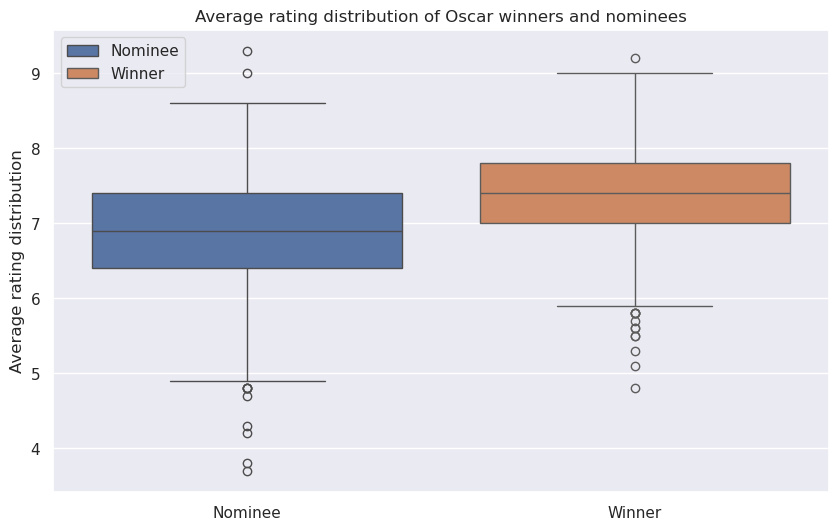

In [2]:
q1.plot_winner_vs_nominees_ratings_all_cat()

At a first look, oscar winners seem to have an higher ratings on average.  
  
However, is is yet unclear if this observation is significant or not !  
So let's perform a t-test to verify that the distribution are indeed different.

In [3]:
q1.print_ttest_winner_vs_nominees_ratings()

T-statistic:  14.984450324469712
P-value:  1.4587409398050492e-48


We observe that the p-value is very small ($<1\%$).  
Thus, we can reject the null hypothesis and initially conclude that the distribution of ratings between Oscar winners and nominees is significantly different.

Good news, the distribution are indeed significantly different.  
However, our analysis is very shalow for now and there are multiple factors that we didn't take into account like: *Ratings could depend on the released year (because of nostalgia of old movies) ?* or even not all movies have the same number of votes.  
In order to refine our analysis, we must take those factor into account.

Let's look at the distribution of ratings over the years (for winner and nominees).

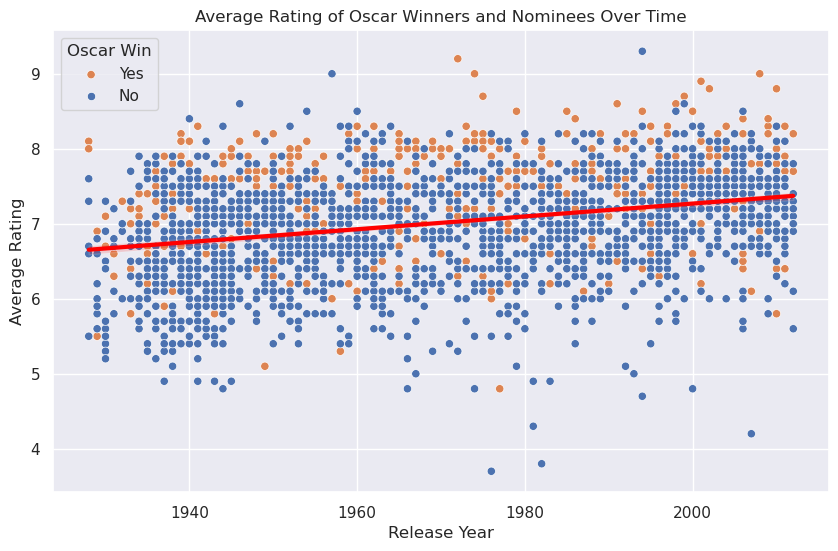

In [4]:
q1.plot_ratings_over_release_year()

We indeed see that ratings seems to naturally increase with the release year.  
Let's confirm this observation with a regression. Here we regress the average ratings on the release year (`release`).

In [5]:
q1.print_reg_ratings_release_year()

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     219.8
Date:                Sun, 15 Dec 2024   Prob (F-statistic):           1.27e-47
Time:                        19:19:57   Log-Likelihood:                -2448.0
No. Observations:                2368   AIC:                             4900.
Df Residuals:                    2366   BIC:                             4911.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.8309      1.136     -8.651      0.0

As we can see, the factor on `release` is positive an significant at a 1% level.  
Thus we can confirm our assumption that the average ratings of movies are naturally growing overtime.  
A possible interpretation could be that people prefer more recent movies.

Now let's look at the relation between the number of votes and the ratings.  

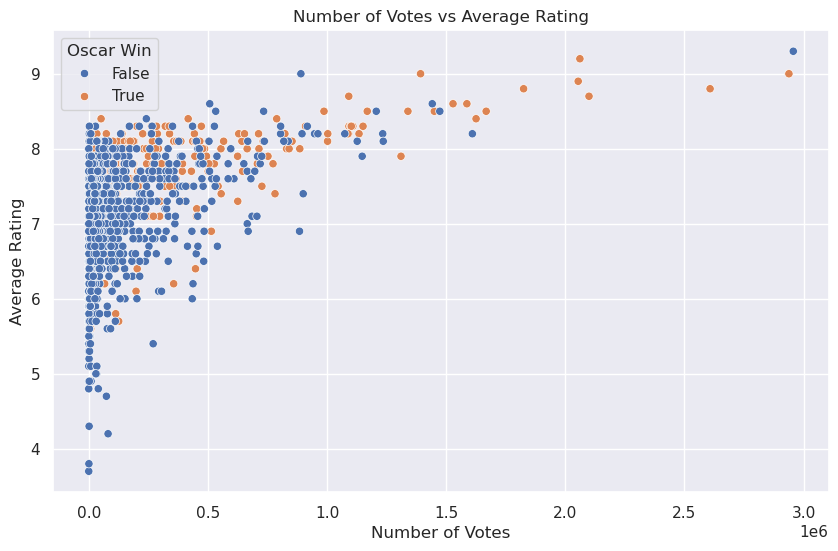

In [6]:
q1.plot_numvotes_vs_ratings()

The relation between the number of votes and the average ratings seems to be non-linear.  
Let's use a log scale to better visualize it.

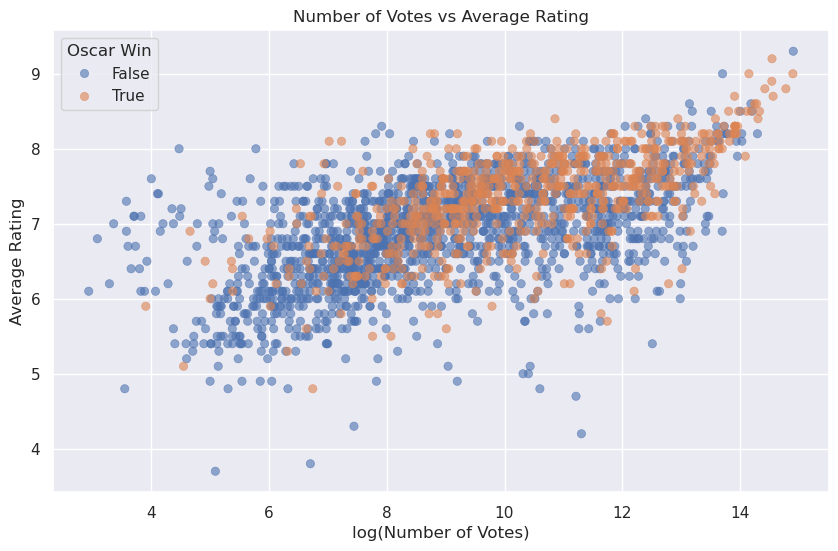

In [7]:
q1.plot_log_numvotes_vs_ratings()

We see that the number of votes and the ratings seems to be correlated in an non linear manner.  
Let's confirm this by computing the Spearman correlation. 

In [8]:
q1.print_spearman_corr_ratings_numVotes()

Spearman correlation between numVotes and averageRating:  0.5939721452138493


We notice a positive spearman correlation which aligns with our previous observations.  
Now, let's confirm the dependency between the average ratings and the log(number of votes) by performing a regression.

In [9]:
q1.print_reg_ratings_log_numVotes()

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     1283.
Date:                Sun, 15 Dec 2024   Prob (F-statistic):          6.18e-225
Time:                        19:19:57   Log-Likelihood:                -2040.1
No. Observations:                2368   AIC:                             4084.
Df Residuals:                    2366   BIC:                             4096.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            5.3107      0.049  

We notice a positive coefficient on the log(number of votes).  
Also, the coefficient is significant at a 1% level which means that the log(number of votes) has a significant impact on the ratings and we must take that into account when studying the impact of winning an oscar.

In order to get the best results, we need to take those factor into account when studying the effect of winning an oscar.  
To do so, we first try to perform a regression on the average ratings taking into account those factors.  
Note that due to the very different distributions between the release year and the nlog(umber of votes), we have normalized the data to get better results from the regression.

In [10]:
q1.print_reg_ratings_all()

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     418.4
Date:                Sun, 15 Dec 2024   Prob (F-statistic):          5.46e-218
Time:                        19:19:57   Log-Likelihood:                -1995.5
No. Observations:                2368   AIC:                             3999.
Df Residuals:                    2364   BIC:                             4022.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               6.9537    

From the regression, we notice that on average, winning an oscar will increase the rating of a movie by 0.21 rating units.

But all oscar categories are not worth the same, indeed winning an oscar for best actor or best picture are likely to have a significantly different impact of the ratings.  
So, let's study the causal effect on ratings of winning an oscar for each category.  

To do so we build a bipartit graph between oscar nominees (control group) and oscar winners (treated group).  
We add an edge between two movies if they have been released the same year (this allows to control for the effect of release year on the ratings).  
Also, we weight each edge by the number of votes difference. And then we create our matching by minimizing the weights. This allows to minimize the influence of the number of votes in our analysis.

However, we must also take into account the fact that a movie might have won an oscar in a category by nominated in another one. Thus, to avoid a bias, we must remove the nominees entries for such movies.

Also, because we study the causal effect of winning an oscar in a single category, we must remove movies that won multiple oscars.

Finally, we filter out categories for which we cannot create enough pairs.  
In our case, we impose a minimum of 10 pairs to get meaningful results.

In [11]:
q1.print_causal_effect_for_base_cat()

Causal effect for category special effects: 0.5333333333333333
Causal effect for category actress in a leading role: 0.4055555555555554
Causal effect for category actor in a supporting role: 0.33749999999999997
Causal effect for category costume design: 0.3230769230769231
Causal effect for category sound recording: 0.30909090909090897
Causal effect for category music (song): 0.2823529411764706
Causal effect for category foreign language film: 0.2727272727272728
Causal effect for category documentary (feature): 0.2600000000000002
Causal effect for category music (scoring of a musical picture): 0.2333333333333333
Causal effect for category actress in a supporting role: 0.1571428571428571
Causal effect for category actor: 0.13076923076923092
Causal effect for category actress: -0.055555555555555504
Causal effect for category music (original song): -0.07333333333333349


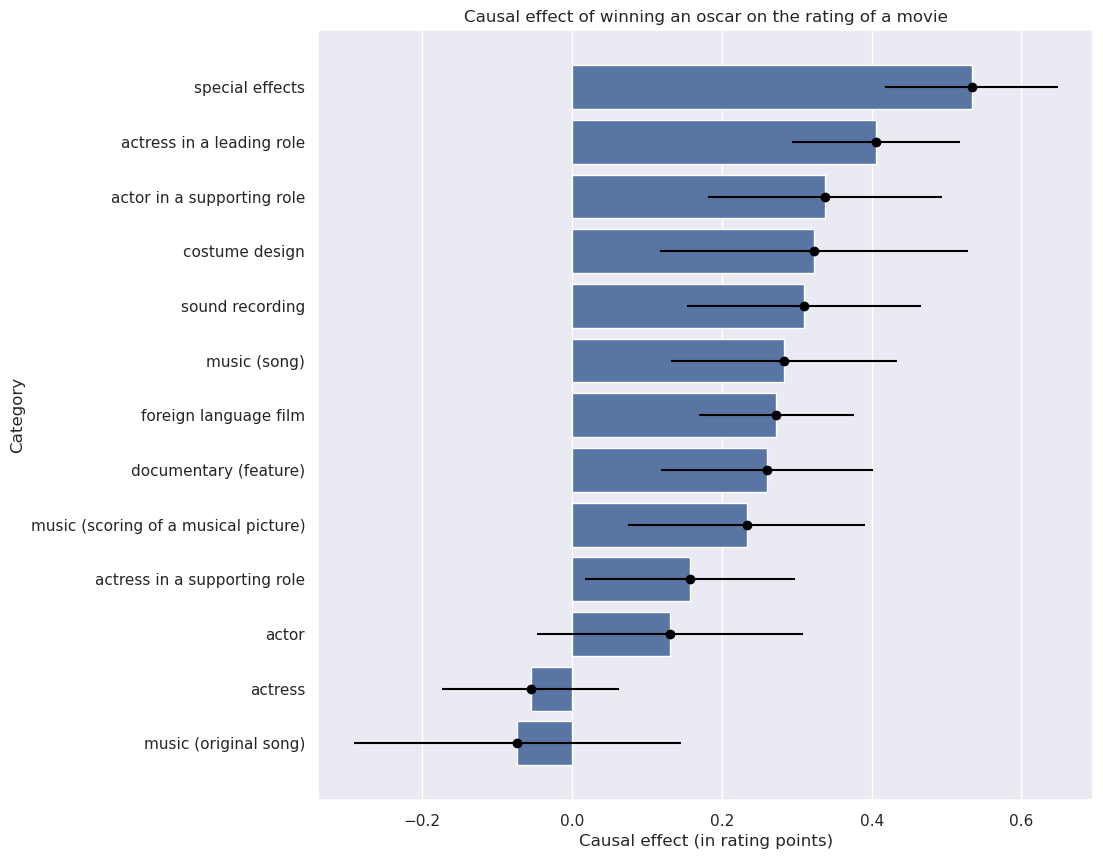

In [12]:
q1.plot_causal_effect_of_base_cat()


Using this approach, we are able to determine the causal effects of only a few categories due to the restrictions of our pipeline.  
We for instance notice the important impact of winning an oscar in special effect which on average increases ratings by 0.53 rating units.

However, there are still many categories for which we weren't able to get the effect.  
Indeed, let's check all the categories for which we have more than 10 entries.


In [13]:
q1.print_oscar_categories(min_samples = 10)

Category: actor in a supporting role, Number of samples: 319
Category: directing, Number of samples: 316
Category: actress in a supporting role, Number of samples: 315
Category: film editing, Number of samples: 308
Category: art direction, Number of samples: 223
Category: cinematography, Number of samples: 210
Category: best picture, Number of samples: 209
Category: actress, Number of samples: 191
Category: actor, Number of samples: 188
Category: sound, Number of samples: 178
Category: costume design, Number of samples: 170
Category: music (original score), Number of samples: 165
Category: sound recording, Number of samples: 160
Category: music (song), Number of samples: 160
Category: actress in a leading role, Number of samples: 150
Category: music (original song), Number of samples: 145
Category: actor in a leading role, Number of samples: 140
Category: cinematography (black-and-white), Number of samples: 133
Category: documentary (feature), Number of samples: 133
Category: foreign l

We see that many categories belong to the same area, it would be nice if we could group them under broader categories.  
To help us create category groups, we will make use of the K-means algorithm.

Concretely, we embed the categories as vectors and ten run k-means for different value of k.  
Given that we only have a few number of samples, the sum of squared errors in functions of k doesn't yield a nice elbow.  
We thus choose the best k based on a manual inspection of the clusters. This yields an optimal k of 12.  
> ⚠️ For this part to work, you must have the spacy english nlp model installed. ⚠️  
> You can install it with the following command: `python -m spacy download en_core_web_md `

In [14]:
optimal_k = 12
q1.print_clusters(optimal_k)

Cluster 0:
art direction, art direction (black-and-white), art direction (color), 

Cluster 1:
writing (original story), writing (screenplay), writing (original screenplay), writing (original motion picture story), documentary (feature), writing (motion picture story), writing (story and screenplay), writing (screenplay—based on material from another medium), writing (story and screenplay—written directly for the screen), writing (story and screenplay—based on factual material or material not previously published or produced), writing (screenplay based on material from another medium), writing (screenplay written directly for the screen), writing (screenplay based on material previously produced or published), writing (adapted screenplay), 

Cluster 2:
outstanding production, outstanding motion picture, best motion picture, best picture, 

Cluster 3:
dance direction, music (song), music (scoring), music (original score), music (scoring of a musical picture), music (music score of a dra

From a first observation, it seems that broader categories like writing or music stand out.  
Now, let's visualize the clusters. To do so, we perform a dimensionality reduction using the PCA method.

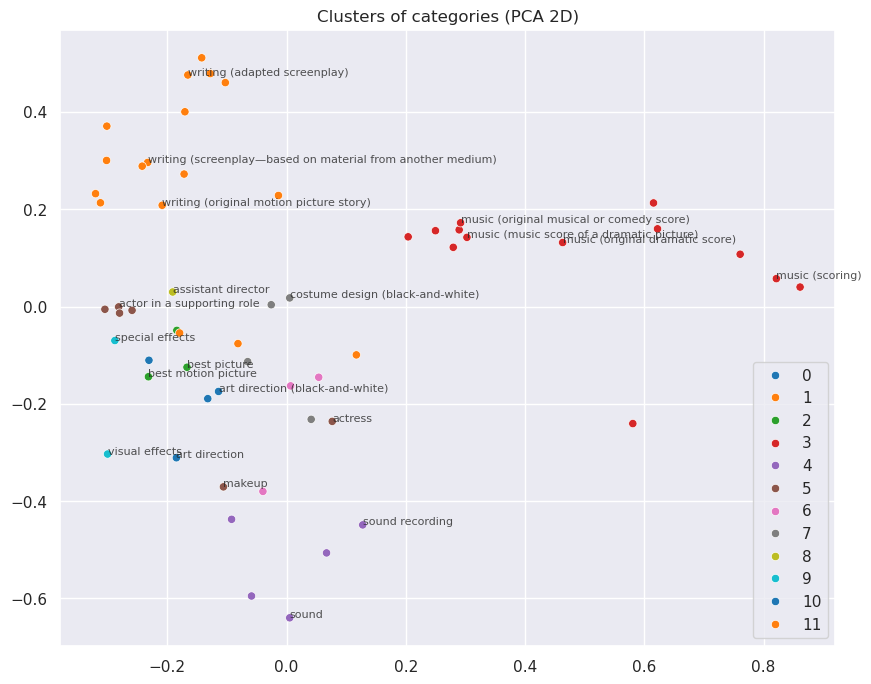

In [15]:
q1.plot_clusters_2d(optimal_k)

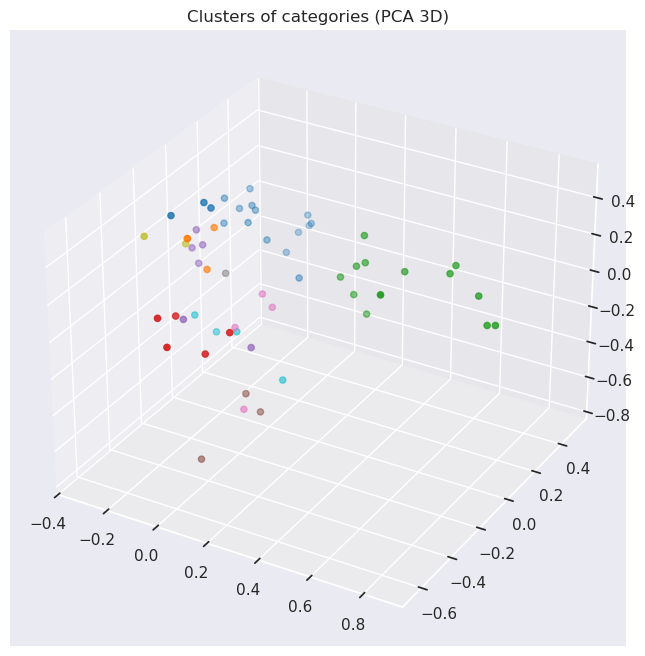

In [16]:
q1.plot_clusters_3d(optimal_k)

Our clustering looks pretty good. However, from a human analysis, we can still see some intuitivly "mis-labeled" categories.  
For instance, it would make more sense for the *actor* category to be grouped with the other acting categories rather than the costume ones (as it is right now).  
Thus, thanks to the relatively few number of datapoints, we do a quick manual clean-up based on the clusters above. 
We end up with the following clusters:

Cluster 0:  **Direction**  
`
art direction, art direction (black-and-white), art direction (color), directing, assistant director, dance direction,
`

Cluster 1:  **Writing**  
`
writing (original story), writing (screenplay), writing (original screenplay), writing (original motion picture story), documentary (feature), writing (motion picture story), writing (story and screenplay), writing (screenplay—based on material from another medium), writing (story and screenplay—written directly for the screen), writing (story and screenplay—based on factual material or material not previously published or produced), writing (screenplay based on material from another medium), writing (screenplay written directly for the screen), writing (screenplay based on material previously produced or published), writing (adapted screenplay), 
`

Cluster 2:  **Best picture**  
`
outstanding production, outstanding motion picture, best motion picture, best picture, 
`

Cluster 3:  **Music**  
`
music (song), music (scoring), music (original score), music (scoring of a musical picture), music (music score of a dramatic picture), music (music score of a dramatic or comedy picture), music (original song), music (scoring of music—adaptation or treatment), music (music score—substantially original), music (song—original for the picture), music (original dramatic score), music (original musical or comedy score), 
`

Cluster 4:  **Sound**  
`
sound recording, sound, sound effects editing, sound editing, sound mixing, 
`

Cluster 5:  **Acting**  
`
actor, actress, actress in a supporting role, actor in a supporting role, actress in a leading role, actor in a leading role,  
`

Cluster 6:  **Cinematography**  
`
cinematography, cinematography (color), cinematography (black-and-white), 
`

Cluster 7:  **Costume**  
`
makeup, costume design (color), costume design (black-and-white), costume design, 
`

Cluster 8:  **Effects**  
`
special effects, visual effects, 
`

Cluster 9:  **Editing**  
`
film editing, foreign language film, animated feature film, 
`


In [17]:
q1.print_causal_effect_for_new_cat()

Causal effect for category effects: 0.445
Causal effect for category cinematography: 0.41904761904761906
Causal effect for category sound: 0.4049999999999998
Causal effect for category costume: 0.31249999999999994
Causal effect for category editing: 0.3078947368421053
Causal effect for category writing: 0.1865853658536587
Causal effect for category direction: 0.08076923076923083
Causal effect for category acting: 0.07863247863247862
Causal effect for category music: 0.026027397260273977


We can now study the causal impact of winning an oscar in those broader categories.

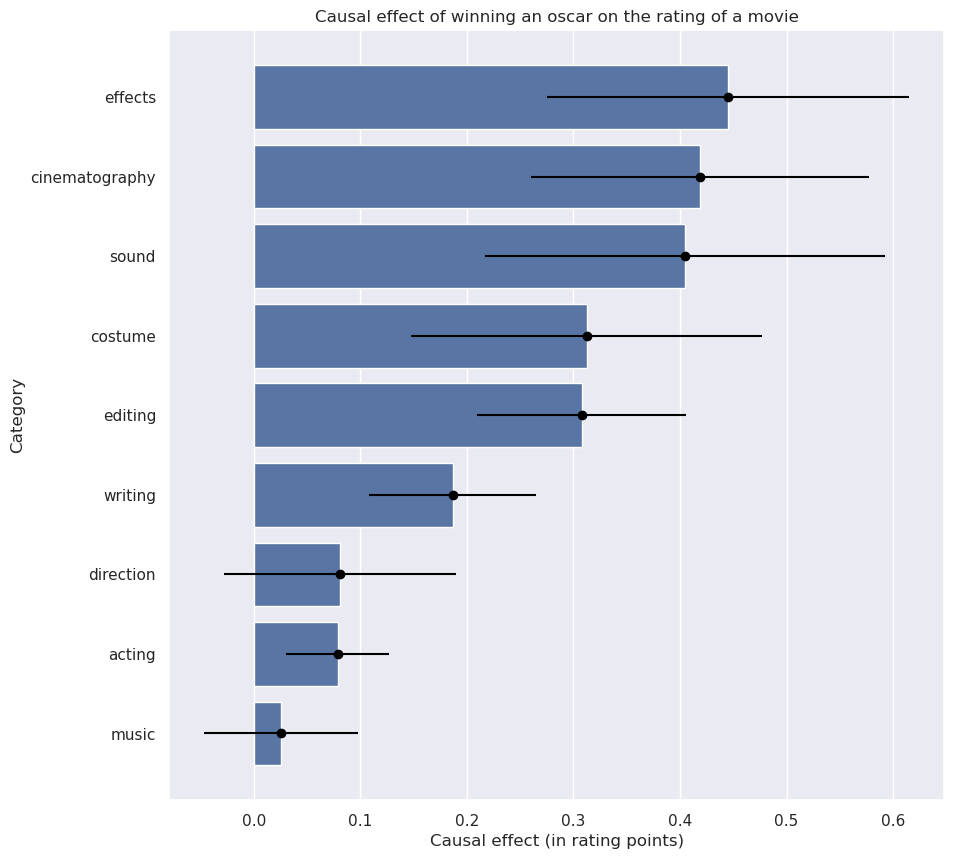

In [18]:
q1.plot_causal_effect_of_new_cat()

We notice that the most influent categories are the one related to the effects, cinematography and sound.  
Note also that for the best picture related categories, we still don't have enough independent points to establish a causal relationship.  
Thus for this category, we'll have to perform further analysis.

Finally, we can also look at the distribution of ratings depending of the number of oscars won.  
Intuitively, we should see higher ratings for movie with multiple oscars.

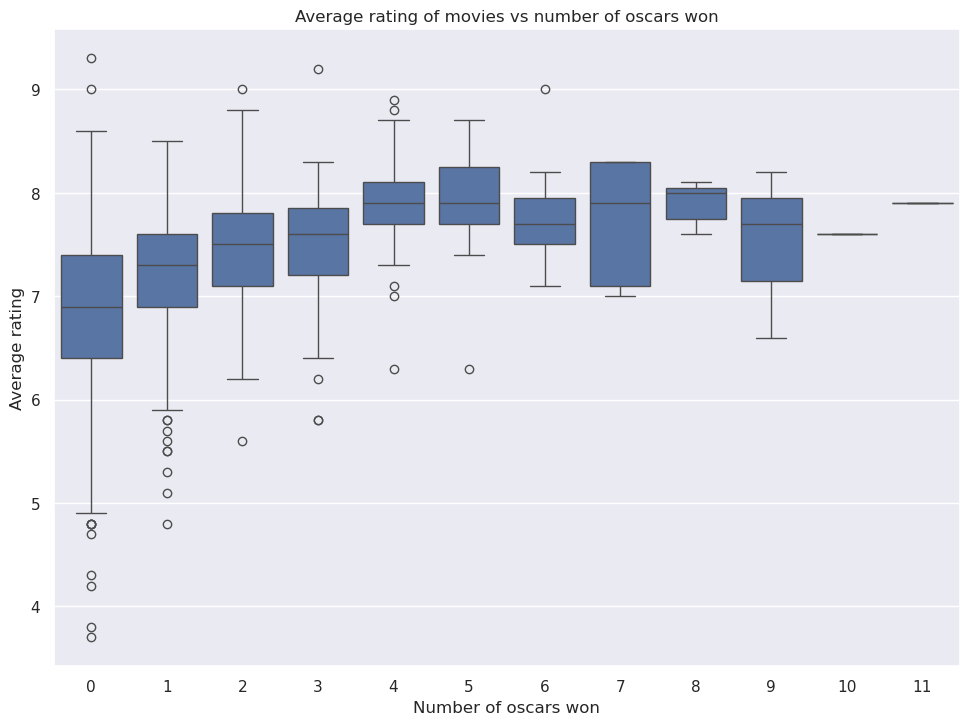

In [19]:
q1.plot_ratings_vs_nb_oscars()

We notice that the distribution follows our expectations by increasing in the number of oscars won.  
This increase seems to be very present for the first five oscars and then it stabilizes.

### 2. Ratings Over Time: Do Oscar Winners "Age Well"?

In order to quantify the "sentiment" of the reviews (positive/negative), we use an open source sentiment analysis tool called "vaderSentiment", which computes the "compound score" of each movie review. The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules of the tool, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This useful metric gives a single unidimensional measure of sentiment for a given sentence.

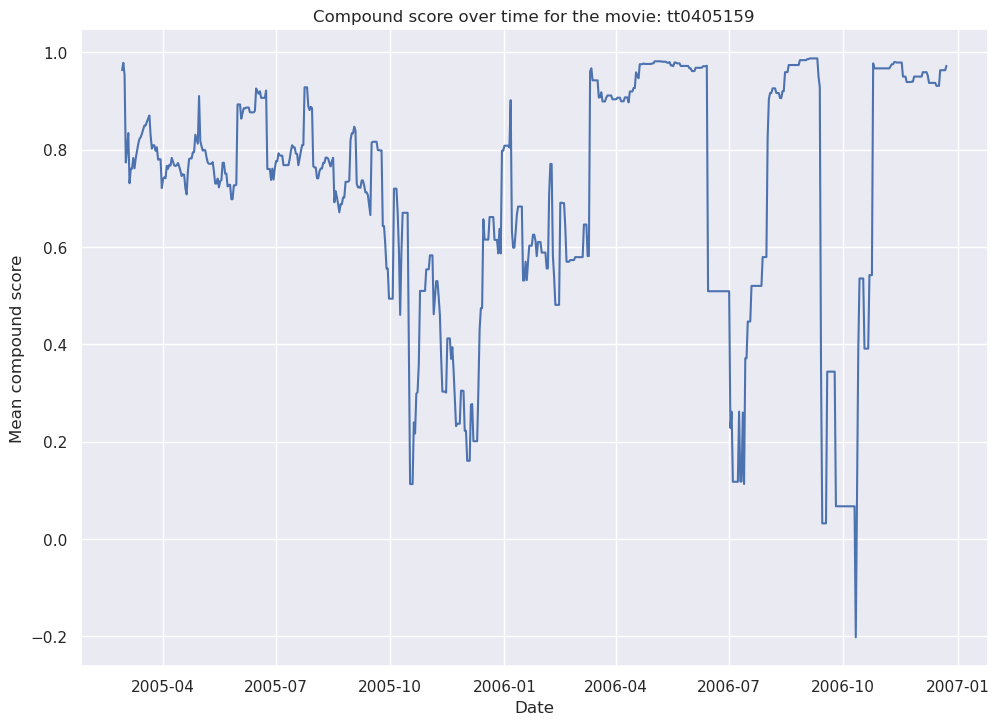

In [20]:
q2.plot_oscar_timeline("compound")

We observe a lot of fluctuations with time. Further analysis with other movies could show us if this is a global trend (here we only plot the case of one award winning movie).

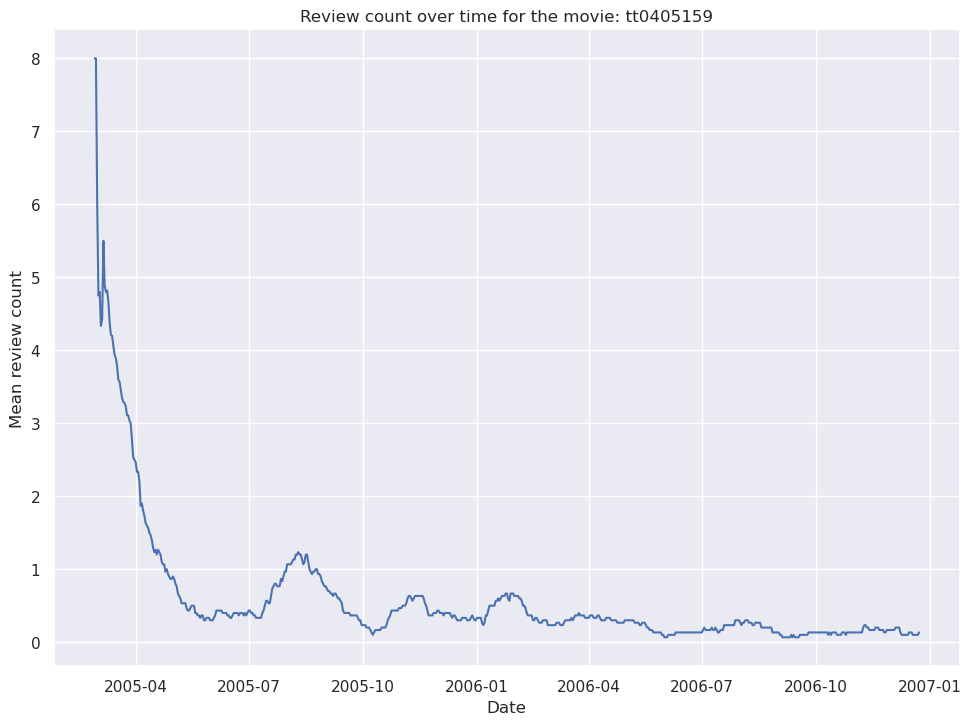

In [21]:
q2.plot_oscar_timeline("count")

The number of reviews decreases with time after the oscar ceremony. This needs to be taken into account when reviewing the compound score timeline (less data with time)

### 3. Impact of High-Profile Actors/Directors on Oscar Wins

### 4. The Oscar Bump: Rating and Review Increases Post-Win

See point 2. for the definition of the "compound score".

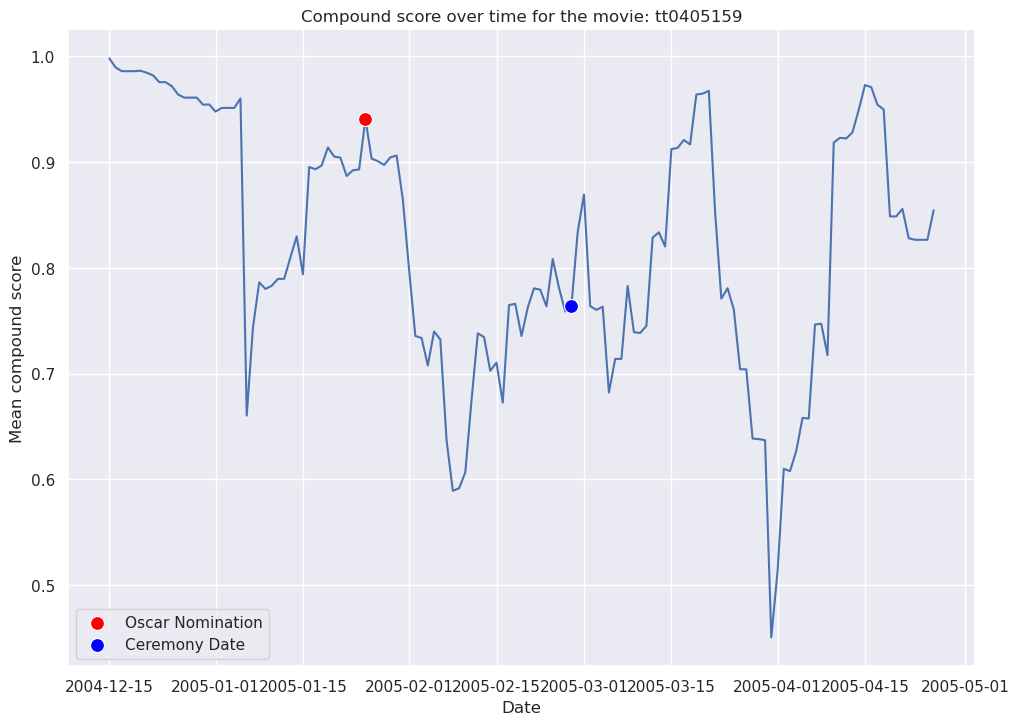

In [25]:
q5.plot_oscar_bump("compound")

We see that the compound score tends to drop after the nomination and rises again after the ceremony (in this case the film won the Oscar)

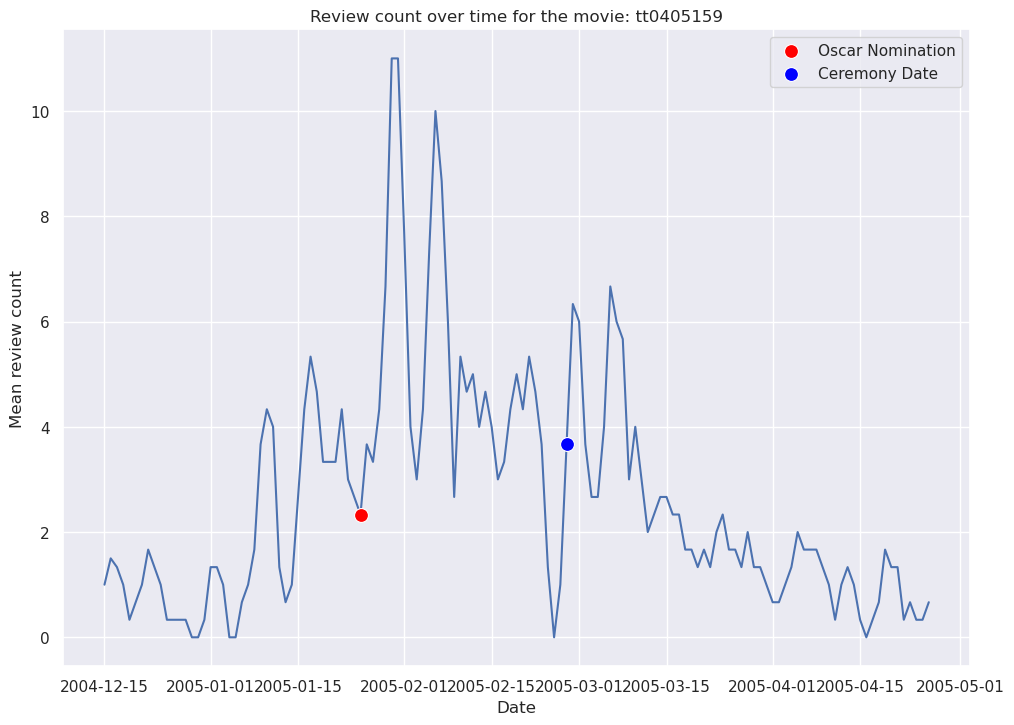

In [26]:
q5.plot_oscar_bump("count")

The number of reviews spikes two times: after the nomination and after the ceremony

### 5. Oscars jury vs Audience biases

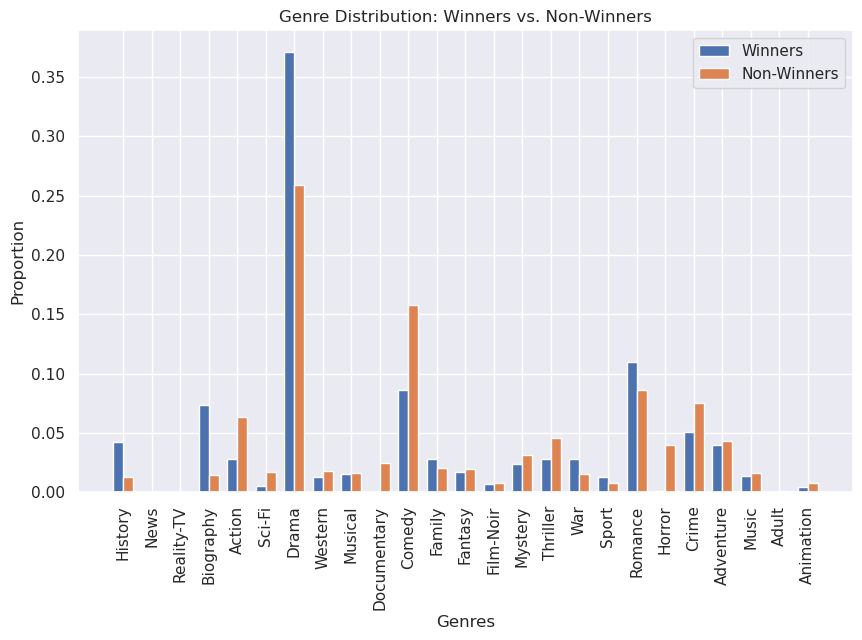

In [27]:
q6.plot_genre_distribution()

The current genre distribution visualization for Oscar winners/nominees versus other films is dominated by the Drama genre, overshadowing differences in less prevalent genres and making it difficult to determine if the Oscar jury has a clear preference for certain genres. To address this, Milestone 3 will introduce adjustments to reduce the visual impact of the Drama genre, enabling a more balanced comparison across all categories and allowing us to identify any genre preferences the Oscar jury may have, as well as its evolution in time.

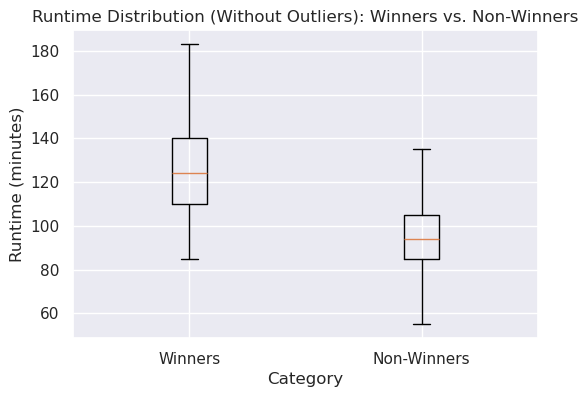

In [28]:
q6.plot_runtime_distribution()

The average runtime of Oscars winners is longer. This could simply be the jury preference but could also be influenced by other factors such as genre and/or evolve over time.

## Summary

[To be completed after the analysis, during Milestone 3]